### Factor Check

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pyodbc
import pickle
import os
os.chdir('T:\\index\\95_곽용하\\운용\\코드\\')
import mf_3 as mf

# DATABASE
conn_quant = pyodbc.connect('driver={SQL Server};server=46.2.90.172;database=quant;uid=index;pwd=samsung@00')
conn_wisefn = pyodbc.connect('driver={SQL Server};server=46.2.90.172;database=wisefn;uid=index;pwd=samsung@00')

In [2]:
open_path = 'T:\\index\\999_quant\\run_kyh\\sector_data\\'
with open(open_path+'past_daily_pbr_cap_adjprc_data.pkl', 'rb') as f:
    df00 = pickle.load(f)

In [15]:

# imsi = pd.DataFrame(df00.groupby(['TRD_DT','FactorGroup_sub','value'])['MKT_VAL'].count()).reset_index()
# imsi[(imsi['FactorGroup_sub']=='Growth')&(imsi['value']==1)&(imsi['TRD_DT']>'2018-01-01')].head(40)

In [3]:
df00.head(5)

,TRD_DT,TRD_DT_BASE,STK_CD,FactorGroup_sub,value,MKT_VAL,CLOSE_PRC,AADJ,ADJ_PRC,BV,PBR,FWD_RTN,FWD_RTN_20
0,2006-01-31,2006-01-31,A000070,Growth,2.0,5.532139e+11,56200.0,0.907261,61944.688463,7.448461e+11,0.742722,-0.042705,-0.040925
1,2006-01-31,2006-01-31,A000100,Growth,2.0,1.483280e+12,173500.0,8.935931,19415.995938,5.631615e+11,2.633845,0.014409,0.000000
2,2006-01-31,2006-01-31,A000140,Growth,4.0,2.370855e+12,123500.0,0.936255,131908.510650,9.376827e+11,2.528419,-0.024291,0.141700
3,2006-01-31,2006-01-31,A000150,Growth,2.0,7.162197e+11,30150.0,1.012448,29779.307184,5.145874e+11,1.391833,-0.054726,0.210614
4,2006-01-31,2006-01-31,A000210,Growth,3.0,2.784000e+12,80000.0,1.000000,80000.000000,2.054444e+12,1.355111,-0.025000,-0.185000


#### 아웃라이어 수정

In [4]:
def ajdust_percentile(x):
    q90 = x.quantile(0.90)
    q10 = x.quantile(0.10)
    return np.where(x>q90, q90, np.where(x<q10,q10,x))

df01 = df00.copy()
df01['adj_PBR'] = df01.groupby(['TRD_DT','FactorGroup_sub','value'])['PBR'].transform(ajdust_percentile)
df01['adj_RTN'] = df01.groupby(['TRD_DT','FactorGroup_sub','value'])['FWD_RTN'].transform(ajdust_percentile)
df01['adj_20_rtn'] = df01.groupby(['TRD_DT','FactorGroup_sub','value'])['FWD_RTN_20'].transform(ajdust_percentile)

#### 시총(제곱근) 가중 계산

In [32]:
df01['sqrt_cap'] = np.sqrt(df01['MKT_VAL'])
df01['cap_pbr'] = df01.sqrt_cap * df01.adj_PBR
df01['cap_fwd_rtn'] = df01.sqrt_cap * df01.adj_RTN
df01['cap_fwd_20d_rtn'] = df01.sqrt_cap * df01.adj_20_rtn

#### PBR

In [7]:
df02 = df01.dropna()
df02 = df02.groupby(['TRD_DT','FactorGroup_sub','value'])['cap_pbr'].sum() / df02.groupby(['TRD_DT','FactorGroup_sub','value'])['sqrt_cap'].sum()
df02 = df02.reset_index()
df02.columns = ['TRD_DT','FactorGroup_sub','value','pbr']

df02_pivot = df02.pivot_table('pbr','TRD_DT',['FactorGroup_sub','value'],dropna=False)

# 5년 평균 값으로 나눔
df02_pivot_avg = df02_pivot.rolling(1250).mean()
df02_pivot_scaled = (df02_pivot / df02_pivot_avg).dropna()

# 4분위 - 1분위
df02_pivot_scaled_stack = df02_pivot_scaled.stack().reset_index()
df02_4q = df02_pivot_scaled_stack[df02_pivot_scaled_stack['value']==4]
df02_1q = df02_pivot_scaled_stack[df02_pivot_scaled_stack['value']==1]

df02_4q.set_index('TRD_DT',inplace=True)
df02_1q.set_index('TRD_DT',inplace=True)

df02_4q = df02_4q.iloc[:,1:]
df02_1q = df02_1q.iloc[:,1:]

df02_ls = df02_4q - df02_1q

df02_ls.drop(['Price-reversal','Price Momentum'],axis=1).tail(750).plot(figsize=(12,6))

#### Daily Rtn

In [37]:
df03 = df01.dropna()
df03 = df03.groupby(['TRD_DT','FactorGroup_sub','value'])['cap_fwd_rtn'].sum() / df03.groupby(['TRD_DT','FactorGroup_sub','value'])['sqrt_cap'].sum()
df03 = df03.reset_index()
df03.columns = ['TRD_DT','FactorGroup_sub','value','fwd_rtn']

In [39]:
df03_pivot = df03.pivot_table('fwd_rtn','TRD_DT',['FactorGroup_sub','value'],dropna=False)

In [41]:
# 4분위 - 1분위
df03_pivot_scaled_stack = df03_pivot.stack().reset_index()
df03_4q = df03_pivot_scaled_stack[df03_pivot_scaled_stack['value']==4]
df03_1q = df03_pivot_scaled_stack[df03_pivot_scaled_stack['value']==1]

df03_4q.set_index('TRD_DT',inplace=True)
df03_1q.set_index('TRD_DT',inplace=True)

df03_4q = df03_4q.iloc[:,1:]
df03_1q = df03_1q.iloc[:,1:]

df03_ls = df03_4q - df03_1q

<AxesSubplot:xlabel='TRD_DT'>

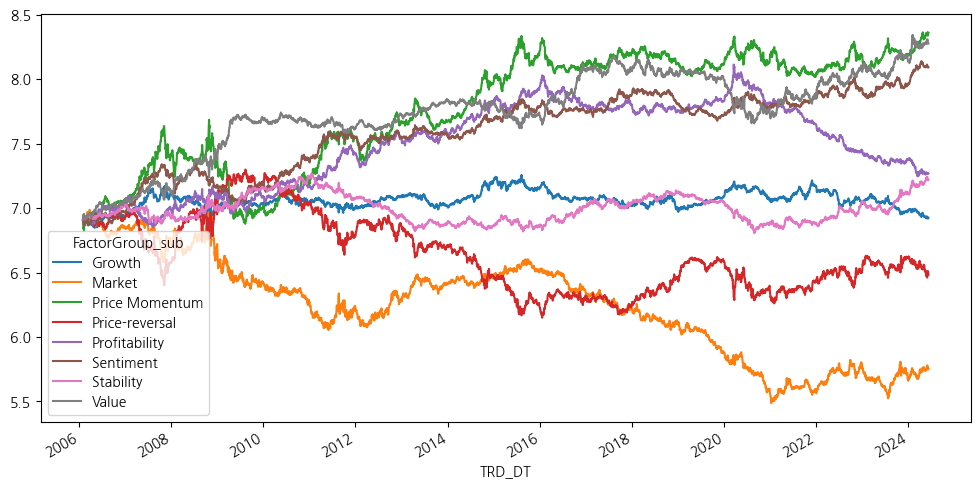

In [53]:
factor_index_history = (1+df03_ls.shift(1)).cumprod()*1000
factor_log_index_history = np.log1p((1+df03_ls.shift(1)).cumprod()*1000)
factor_log_index_history.fillna(np.log1p(1000),inplace=True)
factor_log_index_history.plot(figsize=(12,6))

### 20day Forward Return

In [100]:
df04 = df01.dropna()
df04 = df04.groupby(['TRD_DT','FactorGroup_sub','value'])['cap_fwd_20d_rtn'].sum() / df04.groupby(['TRD_DT','FactorGroup_sub','value'])['sqrt_cap'].sum()
df04 = df04.reset_index()
df04.columns = ['TRD_DT','FactorGroup_sub','value','fwd_20d_rtn']

df04_pivot = df04.pivot_table('fwd_20d_rtn','TRD_DT',['FactorGroup_sub','value'],dropna=False)

# 4분위 - 1분위
df04_pivot_scaled_stack = df04_pivot.stack().reset_index()
df04_4q = df04_pivot_scaled_stack[df04_pivot_scaled_stack['value']==4]
df04_1q = df04_pivot_scaled_stack[df04_pivot_scaled_stack['value']==1]

df04_4q.set_index('TRD_DT',inplace=True)
df04_1q.set_index('TRD_DT',inplace=True)

df04_4q = df04_4q.iloc[:,1:]
df04_1q = df04_1q.iloc[:,1:]

df04_ls = df04_4q - df04_1q

In [101]:
df04_ls

FactorGroup_sub,Growth,Market,Price Momentum,Price-reversal,Profitability,Sentiment,Stability,Value
TRD_DT,,,,,,,,
2006-01-31,-0.007613,0.017911,0.011559,0.018317,-0.022255,-0.006348,0.006183,0.013564
2006-02-01,-0.020325,0.005914,0.018496,0.023088,-0.030313,-0.007153,0.009154,0.010949
2006-02-02,-0.015189,0.015946,0.024380,0.029583,-0.031064,-0.012502,0.010505,0.004622
2006-02-03,-0.021495,-0.005883,0.058223,0.008008,-0.046197,0.004299,0.010168,-0.002967
2006-02-06,-0.028775,0.018859,0.039589,0.024486,-0.047393,0.005768,0.008323,-0.003935
...,...,...,...,...,...,...,...,...
2024-06-03,-0.005962,-0.059707,0.063156,-0.008091,-0.008668,0.047083,-0.009184,-0.034279
2024-06-04,-0.004608,-0.076149,0.080848,-0.028302,-0.017968,0.046392,-0.010800,-0.021594
2024-06-05,-0.012072,-0.067597,0.101735,-0.040153,-0.014447,0.061583,-0.023754,0.000933


### Centrality

<AxesSubplot:title={'center':'Factor Centrality Score'}, xlabel='TRD_DT'>

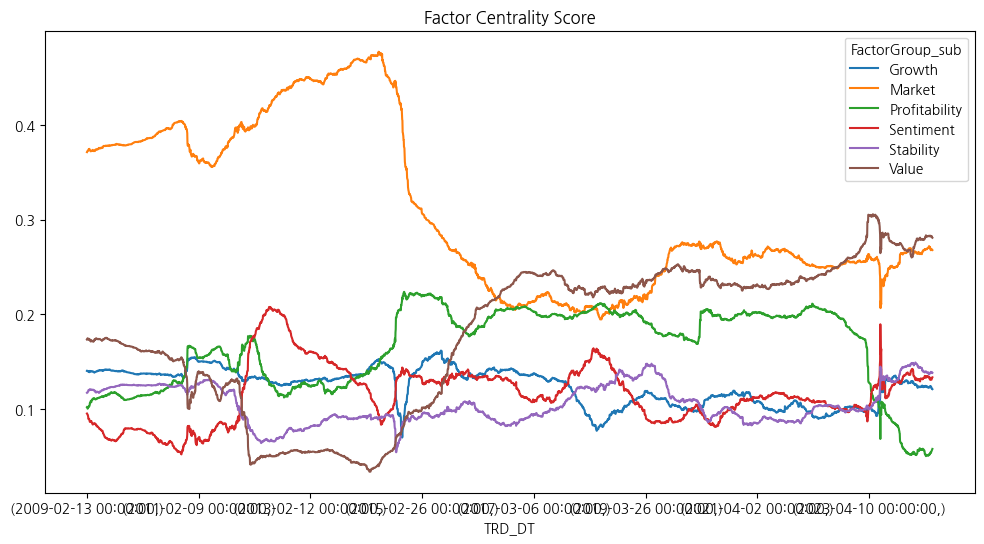

In [45]:
factor_rtn_ls_pivot_1 = df03_ls.drop(['Price Momentum','Price-reversal'],axis=1)
rolling_Cs = [mf.centrality_score(factor_rtn_ls_pivot_1.iloc[i-750:i,:], n=2) for i in range(750, factor_rtn_ls_pivot_1.shape[0]+1)] # rolling 3-year centrality score 
df_rolling_cs = pd.DataFrame(data=rolling_Cs, columns=factor_rtn_ls_pivot_1.columns, index=[factor_rtn_ls_pivot_1.index[749:]])

### RSI

In [64]:
sql_bm = '''  SELECT CONVERT(DATE,TRD_DT,112) TRD_DT, CLOSE_PRC as KSP200
                FROM WISEFN..TS_IDX_DAILY
                WHERE SEC_CD = 'IKS200'
                ORDER BY TRD_DT  '''
df_bm = pd.read_sql(sql_bm, conn_wisefn)
df_bm.set_index('TRD_DT',inplace=True)
df_bm.index = pd.to_datetime(df_bm.index)
df_bm_fwd_rtn = df_bm.pct_change(1).shift(-1)

C:\Users\11149\AppData\Local\Temp\ipykernel_8592\948290215.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_bm = pd.read_sql(sql_bm, conn_wisefn)


In [66]:
df03_ls_bm_adjusted = pd.merge(df03_4q,df_bm_fwd_rtn,'left','TRD_DT')
for col in df03_ls_bm_adjusted.columns[:-1]:
    df03_ls_bm_adjusted[col] -= df03_ls_bm_adjusted['KSP200']


In [80]:
factor_rsi = mf.RSI(df03_ls_bm_adjusted, 120) #6개월

<AxesSubplot:xlabel='TRD_DT'>

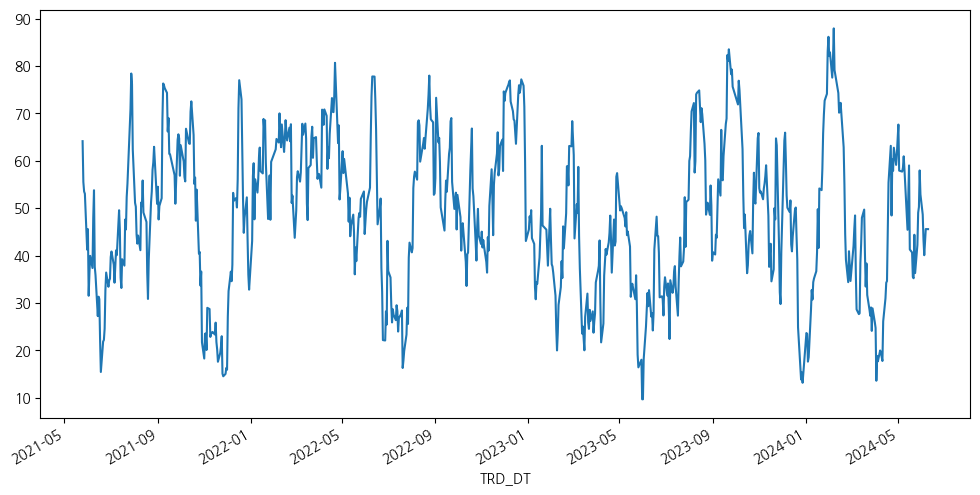

In [116]:
factor_rsi.tail(750)['Value'].plot(figsize=(12,6))

### Factorization

In [88]:
from sklearn.decomposition import NMF

In [92]:
df03_rank = df03_ls.rank(axis=1)

k = 4 # number of factors
model = NMF(n_components=k)

Q = model.fit_transform(df03_rank)
P = model.components_

c:\Users\11149\Anaconda3\envs\algo_trd\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
c:\Users\11149\Anaconda3\envs\algo_trd\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [96]:
R_hat = np.dot(Q,P)
pd.DataFrame(R_hat).rank(axis=1)

,0,1,2,3,4,5,6,7
0,4.0,8.0,1.0,6.0,7.0,2.0,5.0,3.0
1,4.0,6.0,1.0,8.0,3.0,2.0,5.0,7.0
2,3.0,8.0,1.0,7.0,6.0,2.0,4.0,5.0
3,6.0,1.0,8.0,2.0,3.0,7.0,4.0,5.0
4,3.0,5.0,1.0,6.0,2.0,4.0,7.0,8.0
...,...,...,...,...,...,...,...,...
4529,5.0,7.0,2.0,8.0,6.0,1.0,3.0,4.0
4530,7.0,3.0,2.0,8.0,6.0,1.0,4.0,5.0
4531,6.0,1.0,8.0,2.0,3.0,7.0,5.0,4.0
4532,4.0,5.0,8.0,1.0,7.0,6.0,3.0,2.0


### GMM

In [102]:
    ### step 1: GMM _ n_components = 모델의 총 수
from sklearn.mixture import GaussianMixture
data_gmm = df04_ls.copy()
gmm = GaussianMixture(n_components=4, random_state=100)
gmm.fit(data_gmm)
gmm_cluster_labels = gmm.predict(data_gmm)
data_gmm["gmm_cluster"] = gmm_cluster_labels

In [112]:
gmm_summary = data_gmm.groupby('gmm_cluster').describe().stack().reset_index()
gmm_summary.to_excel(open_path+'gmm_summary.xlsx')

In [113]:
data_gmm.to_excel(open_path+'gmm_data.xlsx')

In [114]:
with open(open_path+'gmm_data.pkl', 'wb') as f:
    pickle.dump(data_gmm, f)